In [86]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [87]:
df = pd.read_csv('../combined.csv')

df.columns=["date", "qty"]

In [88]:
df['date'] = pd.to_datetime(df['date'])

df.sort_values('date', inplace=True)

df_2018_2021 = df[(df['date'].dt.year >= 2018) & (df['date'].dt.year <= 2021)]

In [89]:
scaler = MinMaxScaler()
df_2018_2021['qty_normalized'] = scaler.fit_transform(df_2018_2021['qty'].values.reshape(-1,1))
sequence_length = 4

C:\Users\TANU SHREE\AppData\Local\Temp\ipykernel_8160\1869378732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2021['qty_normalized'] = scaler.fit_transform(df_2018_2021['qty'].values.reshape(-1,1))


In [90]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [91]:
X_train, y_train = create_sequences(df_2018_2021['qty_normalized'].values, sequence_length)

df_2022 = df[df['date'].dt.year == 2022]

df_2022['qty_normalized'] = scaler.transform(df_2022['qty'].values.reshape(-1,1))

X_test, y_test = create_sequences(df_2022['qty_normalized'].values, sequence_length)

C:\Users\TANU SHREE\AppData\Local\Temp\ipykernel_8160\84995266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['qty_normalized'] = scaler.transform(df_2022['qty'].values.reshape(-1,1))


In [92]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)
predictions = model.predict(X_test)

Epoch 1/100
34/34 [==============================] - 3s 3ms/step - loss: 0.0463
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0334
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0326
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0320
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0319
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0312
Epoch 11/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0310
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 13/100
34/34 [=================

In [93]:
predictions_actual = scaler.inverse_transform(predictions)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test = df_2022['date'].values[sequence_length:]

results_df = pd.DataFrame({'Date': dates_test, 'Actual Quantity': y_test_actual.flatten(), 'Predicted Quantity': predictions_actual.flatten()})
print(results_df)

          Date  Actual Quantity  Predicted Quantity
0   2022-01-09         757974.0         908518.6875
1   2022-01-10        2250363.0         911686.5000
2   2022-01-11        1558639.0         759493.3125
3   2022-01-12        1432781.0         703432.5000
4   2022-01-15         425559.0         727948.0625
..         ...              ...                 ...
255 2022-12-27        1029546.0         905701.5625
256 2022-12-28         971387.0         829871.0625
257 2022-12-29         231274.0         834512.5000
258 2022-12-30         358590.0         934268.5000
259 2022-12-31        1020553.0         972269.1250

[260 rows x 3 columns]


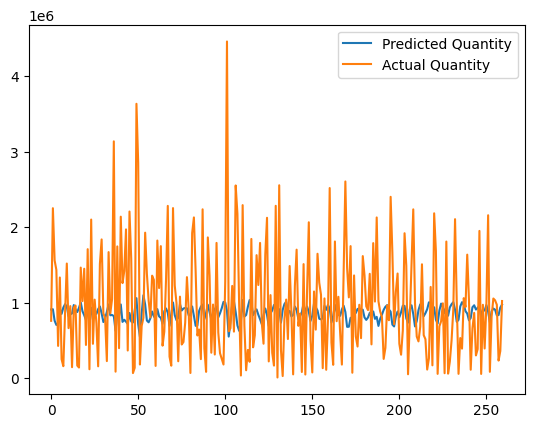

In [99]:
plt.plot(predictions_actual, label='Predicted Quantity')
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Quantity')
plt.legend()
plt.show()

In [98]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_actual, predictions_actual)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 572831.9627403846
